<a href="https://colab.research.google.com/github/nabisan/Long-Only-Strategy-Hypothesis/blob/main/Buy_Low_Sell_High_Try_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If the stock closes lower for the day, we will purchase at the opening of the next trading day if we did not have the stock on-hand. If the stock closes higher for the day, we will sell the stock at the opening of the next day if we have the stock on-hand. We will take no action if we encounter the trading signal to sell but have no stock on-hand or the trading signal to buy if we already have the stock on-hand.

In [31]:
!pip install yfinance edgar seaborn

In [2]:
# random seed number for reproducible results
seedNum = 888

In [7]:
import os
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import json
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [34]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose = False

# Configure the plotting style
import seaborn as sns
sns.set()

In [35]:
start_date = datetime(2025,8, 1)
print("Starting date:", start_date)
end_date = datetime.now()
print("Ending date:", end_date)

stock_symbol = 'GOOG'

initial_capital = 2000.00

Starting date: 2025-08-01 00:00:00
Ending date: 2025-11-29 08:42:21.133639


In [36]:
import yfinance as yf

stock_yahoo = yf.download(stock_symbol, start=start_date, end=end_date, multi_level_index=False, auto_adjust=False)
print(len(stock_yahoo), 'data points retrieved from the API call.')

[*********************100%***********************]  1 of 1 completed

84 data points retrieved from the API call.


In [37]:
stock_yahoo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2025-08-01 to 2025-11-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  84 non-null     float64
 1   Close      84 non-null     float64
 2   High       84 non-null     float64
 3   Low        84 non-null     float64
 4   Open       84 non-null     float64
 5   Volume     84 non-null     int64  
dtypes: float64(5), int64(1)
memory usage: 4.6 KB


In [38]:
stock_yahoo.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2025-08-01,189.780365,189.949997,191.617996,188.699997,189.779999,21236700
2025-08-04,195.575195,195.750000,196.080002,190.919998,191.175003,23386000
2025-08-05,195.145584,195.320007,198.699997,194.675003,195.544998,19010200
2025-08-06,196.744156,196.919998,197.380005,194.466995,195.250000,15383700
2025-08-07,197.103821,197.279999,198.369995,195.220001,197.710007,14660600


In [39]:
stock_yahoo.tail()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2025-11-21,299.649994,299.649994,303.959991,294.359985,296.869995,43670600
2025-11-24,318.470001,318.470001,319.799988,309.399994,311.010010,55311800
2025-11-25,323.640015,323.640015,328.670013,317.816010,326.799988,50899300
2025-11-26,320.279999,320.279999,324.989990,317.200012,320.779999,29839600
2025-11-28,320.119995,320.119995,326.880005,316.940002,323.429993,19695800


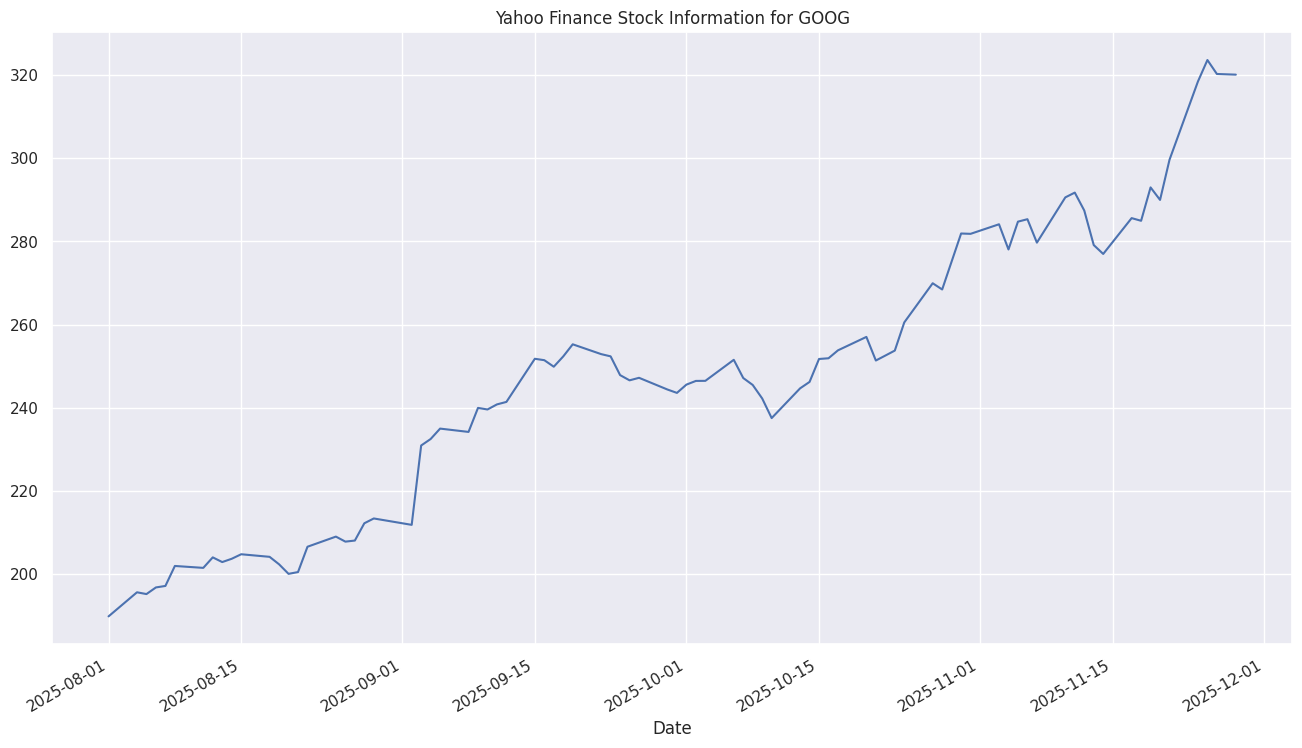

In [40]:
title_string = 'Yahoo Finance Stock Information for ' + stock_symbol
stock_yahoo['Adj Close'].plot(figsize=(16,9), title=title_string)
plt.show()

In [41]:
# The data source and pricing columns to use for modeling
trading_model = stock_yahoo.loc[:, ['Open', 'Adj Close']]

# Set up the standard column name for modeling
trading_model.rename(columns={'Open': 'open_price', 'Adj Close': 'close_price'}, inplace=True)
trading_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2025-08-01 to 2025-11-28
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open_price   84 non-null     float64
 1   close_price  84 non-null     float64
dtypes: float64(2)
memory usage: 2.0 KB


In [42]:
trading_model.head()

,open_price,close_price
Date,,
2025-08-01,189.779999,189.780365
2025-08-04,191.175003,195.575195
2025-08-05,195.544998,195.145584
2025-08-06,195.250000,196.744156
2025-08-07,197.710007,197.103821


In [44]:
# Generating the trading signals
trading_model['price_change'] = trading_model['close_price'].diff()
trading_model['price_lower'] = np.where(trading_model['price_change']<0, True, False)
trading_model['lower_previous'] = trading_model['price_lower'].shift(1)
trading_model.dropna(inplace=True)

trading_model.head(10)

,open_price,close_price,price_change,price_lower,lower_previous
Date,,,,,
2025-08-04,191.175003,195.575195,5.794830,False,False
2025-08-05,195.544998,195.145584,-0.429611,True,False
2025-08-06,195.250000,196.744156,1.598572,False,True
2025-08-07,197.710007,197.103821,0.359665,False,False
2025-08-08,197.979996,201.909531,4.805710,False,False
2025-08-11,201.554993,201.449951,-0.459579,True,False
2025-08-12,202.095001,203.977692,2.527740,False,True
2025-08-13,204.979996,202.848694,-1.128998,True,False
2025-08-14,202.559998,203.638000,0.789307,False,True


In [45]:
trading_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83 entries, 2025-08-04 to 2025-11-28
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   open_price      83 non-null     float64
 1   close_price     83 non-null     float64
 2   price_change    83 non-null     float64
 3   price_lower     83 non-null     bool   
 4   lower_previous  83 non-null     object 
dtypes: bool(1), float64(3), object(1)
memory usage: 3.3+ KB


In [46]:
# Construct a portfolio to track the transactions and returns
portfolio = pd.DataFrame(index=trading_model.index, columns=['trade_action', 'qty_onhand', 'cost_basis', 'sold_transaction',
                                                             'cash_onhand', 'position_value', 'total_position', 'accumu_return'])
portfolio.iloc[0]['trade_action'] = 0
portfolio.iloc[0]['qty_onhand'] = 0
portfolio.iloc[0]['cost_basis'] = 0.00
portfolio.iloc[0]['sold_transaction'] = 0.00
portfolio.iloc[0]['cash_onhand'] = initial_capital
portfolio.iloc[0]['position_value'] = 0.00
portfolio.iloc[0]['total_position'] = initial_capital
portfolio.iloc[0]['accumu_return'] = portfolio.iloc[0]['total_position'] - initial_capital

for i in range(1, len(portfolio)):
    if trading_model.iloc[i]['lower_previous'] and (portfolio.iloc[i-1]['qty_onhand'] == 0):
        portfolio.iloc[i]['trade_action'] = 1
        portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
        portfolio.iloc[i]['cost_basis'] = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
        portfolio.iloc[i]['sold_transaction'] = 0.00
        portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] - portfolio.iloc[i]['cost_basis']
    elif (not trading_model.iloc[i]['lower_previous']) and (portfolio.iloc[i-1]['qty_onhand'] > 0):
        portfolio.iloc[i]['trade_action'] = -1
        portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
        portfolio.iloc[i]['cost_basis'] = 0.00
        portfolio.iloc[i]['sold_transaction'] = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
        portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] - portfolio.iloc[i]['sold_transaction']
    else:
        portfolio.iloc[i]['trade_action'] = 0
        portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand']
        portfolio.iloc[i]['cost_basis'] = 0.00
        portfolio.iloc[i]['sold_transaction'] = 0.00
        portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand']
    portfolio.iloc[i]['position_value'] = trading_model.iloc[i]['close_price'] * portfolio.iloc[i]['qty_onhand']
    portfolio.iloc[i]['total_position'] = portfolio.iloc[i]['cash_onhand'] + portfolio.iloc[i]['position_value']
    portfolio.iloc[i]['accumu_return'] = portfolio.iloc[i]['total_position'] - initial_capital

portfolio.head(10)

/tmp/ipython-input-3946387029.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  portfolio.iloc[0]['trade_action'] = 0
/tmp/ipython-input-3946387029.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are s

,trade_action,qty_onhand,cost_basis,sold_transaction,cash_onhand,position_value,total_position,accumu_return
Date,,,,,,,,
2025-08-04,0,0,0.0,0.0,2000.0,0.0,2000.0,0.0
2025-08-05,0,0,0.0,0.0,2000.0,0.0,2000.0,0.0
2025-08-06,1,1,195.25,0.0,1804.75,196.744156,2001.494156,1.494156
2025-08-07,-1,0,0.0,-197.710007,2002.460007,0.0,2002.460007,2.460007
2025-08-08,0,0,0.0,0.0,2002.460007,0.0,2002.460007,2.460007
2025-08-11,0,0,0.0,0.0,2002.460007,0.0,2002.460007,2.460007
2025-08-12,1,1,202.095001,0.0,1800.365005,203.977692,2004.342697,4.342697
2025-08-13,-1,0,0.0,-204.979996,2005.345001,0.0,2005.345001,5.345001
2025-08-14,1,1,202.559998,0.0,1802.785004,203.638,2006.423004,6.423004


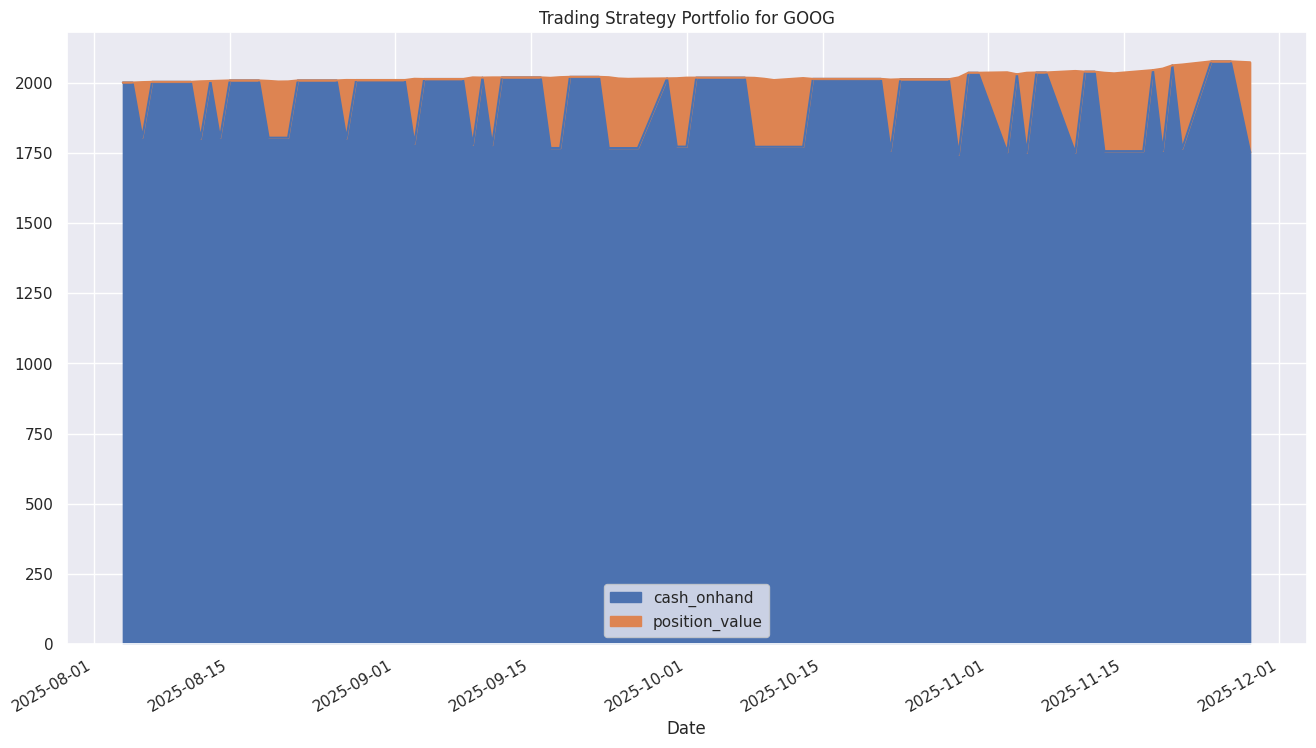

In [47]:
title_string = 'Trading Strategy Portfolio for ' + stock_symbol
portfolio[['cash_onhand','position_value']].plot.area(figsize=(16,9), stacked=True)
plt.title(title_string)
plt.show()

In [48]:
benchmark = pd.DataFrame(index=trading_model.index, columns=['trade_action', 'qty_onhand', 'cash_onhand', 'position_value', 'total_position', "accumu_return"])
benchmark.iloc[0]['trade_action'] = 1
benchmark.iloc[0]['qty_onhand'] = benchmark.iloc[0]['trade_action']
benchmark.iloc[0]['cash_onhand'] = initial_capital - (trading_model.iloc[0]['open_price'] * benchmark.iloc[0]['trade_action'])
benchmark.iloc[0]['position_value'] = trading_model.iloc[0]['open_price']
benchmark.iloc[0]['total_position'] = initial_capital
benchmark.iloc[0]['accumu_return'] = benchmark.iloc[0]['total_position'] - initial_capital

for i in range(1, len(portfolio)):
    benchmark.iloc[i]['trade_action'] = 0
    benchmark.iloc[i]['qty_onhand'] = benchmark.iloc[i-1]['qty_onhand']
    benchmark.iloc[i]['cash_onhand'] = benchmark.iloc[i-1]['cash_onhand']
    benchmark.iloc[i]['position_value'] = trading_model.iloc[i]['close_price'] * benchmark.iloc[i]['qty_onhand']
    benchmark.iloc[i]['total_position'] = benchmark.iloc[i]['cash_onhand'] + benchmark.iloc[i]['position_value']
    benchmark.iloc[i]['accumu_return'] = benchmark.iloc[i]['total_position'] - initial_capital

benchmark.head(10)

/tmp/ipython-input-1167335881.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  benchmark.iloc[0]['trade_action'] = 1
/tmp/ipython-input-1167335881.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are s

,trade_action,qty_onhand,cash_onhand,position_value,total_position,accumu_return
Date,,,,,,
2025-08-04,1,1,1808.824997,191.175003,2000.0,0.0
2025-08-05,0,1,1808.824997,195.145584,2003.970581,3.970581
2025-08-06,0,1,1808.824997,196.744156,2005.569153,5.569153
2025-08-07,0,1,1808.824997,197.103821,2005.928818,5.928818
2025-08-08,0,1,1808.824997,201.909531,2010.734528,10.734528
2025-08-11,0,1,1808.824997,201.449951,2010.274948,10.274948
2025-08-12,0,1,1808.824997,203.977692,2012.802689,12.802689
2025-08-13,0,1,1808.824997,202.848694,2011.673691,11.673691
2025-08-14,0,1,1808.824997,203.638,2012.462997,12.462997


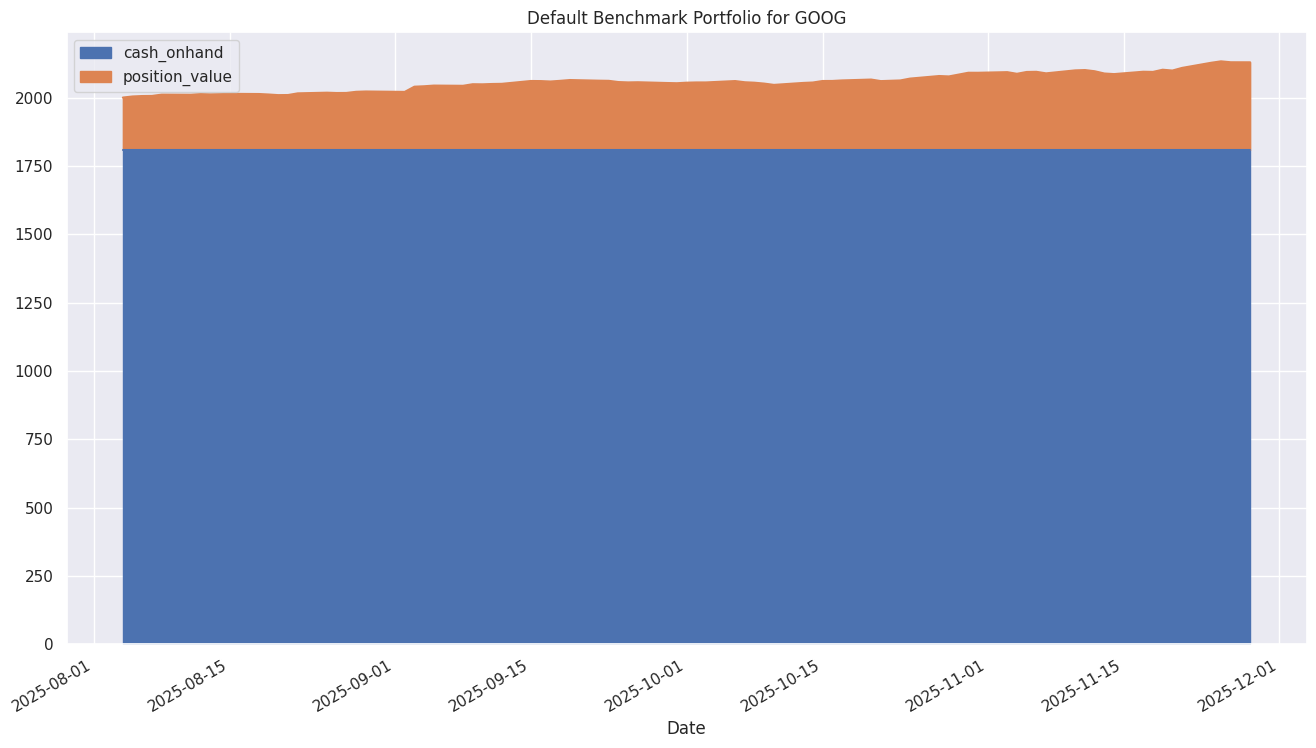

In [49]:
title_string = 'Default Benchmark Portfolio for ' + stock_symbol
benchmark[['cash_onhand','position_value']].plot.area(figsize=(16,9), stacked=True)
plt.title(title_string)
plt.show()

In [50]:
#A Performance data frame to display the returns from the strategy and benchmark
performance = pd.DataFrame(index=trading_model.index)
performance['strategy'] = portfolio['accumu_return']
performance['benchmark'] = benchmark['accumu_return']

performance.head(10)

,strategy,benchmark
Date,,
2025-08-04,0.0,0.0
2025-08-05,0.0,3.970581
2025-08-06,1.494156,5.569153
2025-08-07,2.460007,5.928818
2025-08-08,2.460007,10.734528
2025-08-11,2.460007,10.274948
2025-08-12,4.342697,12.802689
2025-08-13,5.345001,11.673691
2025-08-14,6.423004,12.462997


In [51]:
print('The accumulated return/loss from the trading strategy: %.2f percent' % (performance.iloc[-1]['strategy'] / initial_capital * 100))
print('The accumulated return/loss from the long-only benchmark: %.2f percent' % (performance.iloc[-1]['benchmark'] / initial_capital * 100))

The accumulated return/loss from the trading strategy: 3.61 percent
The accumulated return/loss from the long-only benchmark: 6.45 percent


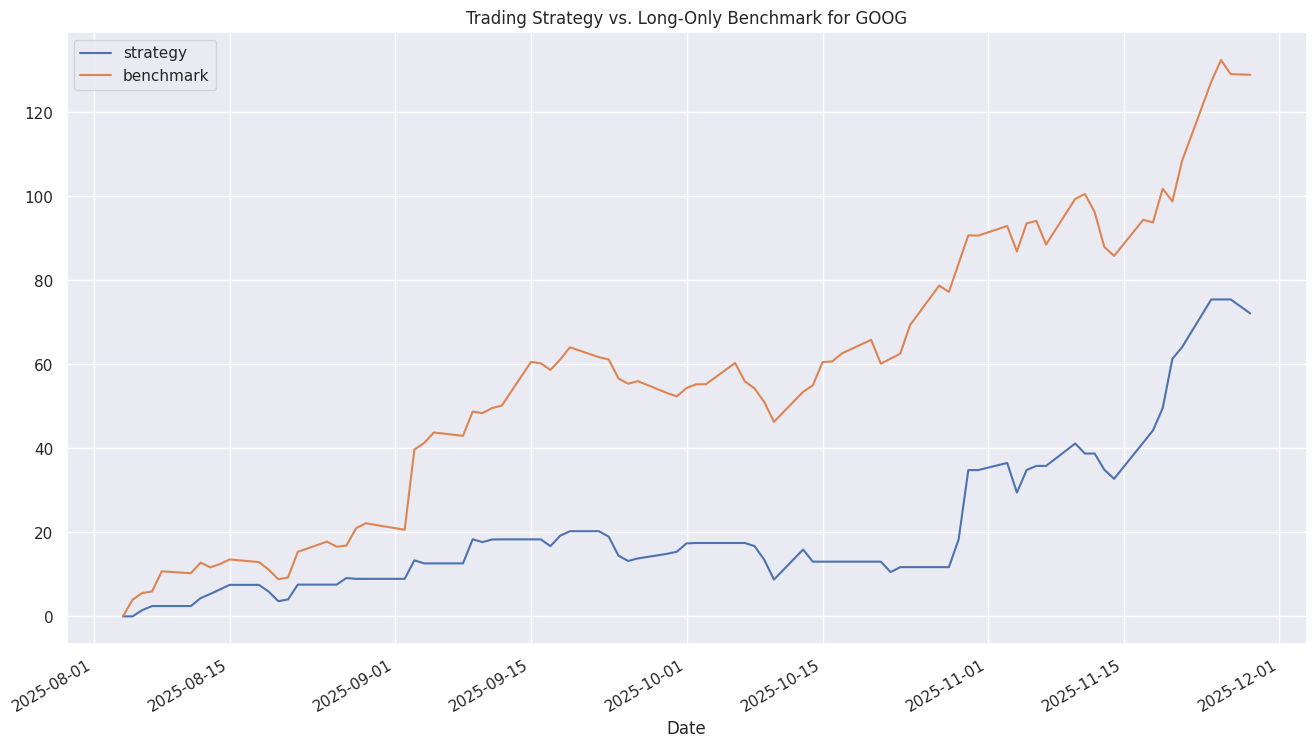

In [52]:
title_string = 'Trading Strategy vs. Long-Only Benchmark for ' + stock_symbol
performance[['strategy','benchmark']].plot(figsize=(16,9), title=title_string)
plt.show()

In [53]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:07:26.306713
